### Classificação de textos para análise de sentimentos

Base de dados 

Instruções:
- O objetivo deste trabalho é criar um modelo binário de aprendizado de máquina para classificação de textos. 
Para isso, será utilizado a base de dados [IMDb](http://ai.stanford.edu/~amaas/data/sentiment/), que consiste de dados textuais de críticas positivas e negativas de filmes
- Uma vez treinado, o modelo deve ter uma função `predict` que recebe uma string como parâmetro e retorna o valor 1 ou 0, aonde 1 significa uma crítica positiva e 0 uma crítica negativa
- O pré-processamento pode ser desenvolvidado conforme desejar (ex.: remoção de stopwords, word embedding, one-hot encoding, char encoding)
- É preferível que seja empregado um modelo de recorrência (ex.: rnn, lstm, gru) para a etapa de classificação
- Documente o código (explique sucintamente o que cada função faz, insira comentários em trechos de código relevantes)
- **Atenção**: Uma vez treinado o modelo final, salve-o no diretório do seu projeto e crie uma célula ao final do notebook contendo uma função de leitura deste arquivo, juntamente com a execução da função `predict`

Sugestões:
- Explorar a base de dados nas células iniciais do notebook para ter um melhor entendimento do problema, distribuição dos dados, etc
- Após desenvolver a estrutura de classificação, é indicado fazer uma busca de hiperparâmetros e comparar os resultados obtidos em diferentes situações

Prazo de entrega:
- 01-08-2021 às 23:59hs GMT-3

Formato preferível de entrega:
- Postar no portal Ava da disciplina o link do projeto no github (ou anexar o projeto diretamente no portal Ava)

luann.porfirio@gmail.com

# Universidade: FURB
## Curso: Data Science
### Disciplina: Deep Learning
#### Aluno: Diego Leonardo Urban

### Import all libraries

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchtext import datasets
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, BatchNormalization, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model

### Load Dataset

In [2]:
train_iter, test_iter = datasets.IMDB()
dataset_imdb = list(train_iter + test_iter)
df_imdb_raw = pd.DataFrame(data=dataset_imdb, columns=['sentiment', 'review'])

aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:05<00:00, 14.7MB/s]


### Explore Dataset

In [3]:
df_imdb_raw.shape

(50000, 2)

In [4]:
df_imdb_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  50000 non-null  object
 1   review     50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df_imdb_raw.describe()

,sentiment,review
count,50000,50000
unique,2,49582
top,neg,Loved today's show!!! It was a variety and not...
freq,25000,5


In [6]:
df_imdb_raw.nunique()

sentiment        2
review       49582
dtype: int64

In [7]:
df_imdb_raw.head()

,sentiment,review
0,neg,I rented I AM CURIOUS-YELLOW from my video sto...
1,neg,"""I Am Curious: Yellow"" is a risible and preten..."
2,neg,If only to avoid making this type of film in t...
3,neg,This film was probably inspired by Godard's Ma...
4,neg,"Oh, brother...after hearing about this ridicul..."


In [8]:
df_imdb_raw.tail()

,sentiment,review
49995,pos,Just got around to seeing Monster Man yesterda...
49996,pos,I got this as part of a competition prize. I w...
49997,pos,I got Monster Man in a box set of three films ...
49998,pos,"Five minutes in, i started to feel how naff th..."
49999,pos,I caught this movie on the Sci-Fi channel rece...


In [9]:
df_imdb_raw[df_imdb_raw.duplicated()]

,sentiment,review
168,neg,I am not so much like Love Sick as I image. Fi...
664,neg,Holy freaking God all-freaking-mighty. This mo...
701,neg,"The story and the show were good, but it was r..."
3070,neg,I watched this movie when Joe Bob Briggs hoste...
3591,neg,"I like Chris Rock, but I feel he is wasted in ..."
...,...,...
49911,pos,I watched Pola X because Scott Walker composed...
49912,pos,Leos Carax has made 3 great movies: Boys Meet ...
49913,pos,Leos Carax is brilliant and is one of the best...
49914,pos,I've tried to reconcile why so many bad review...


Há casos de registros duplicados no dataset.

Necessário transformar para lowercase, remover caracteres que não são alfabeto e stopwords.


### Clean Dataset

In [10]:
df_cleaned = df_imdb_raw.drop_duplicates()

In [11]:
df_cleaned.describe()

,sentiment,review
count,49582,49582
unique,2,49582
top,pos,"This movie was like a bad train wreck, as horr..."
freq,24884,1


In [12]:
nltk.download('stopwords')
english_stops = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
X, y = df_imdb_raw['review'],df_imdb_raw['sentiment']

In [14]:
# Limpeza do review
# Remover caracteres
X = X.replace({'<.*?>': ''}, regex = True)
X = X.replace({'[^A-Za-z]': ' '}, regex = True)

# Stopwords
X = X.apply(lambda review: [w for w in review.split() if w not in english_stops])

# Lowercase
X = X.apply(lambda review: [w.lower() for w in review])

In [15]:
# Encode do sentiment
y = y.replace('pos', 1)
y = y.replace('neg', 0)

In [16]:
# Split treino / teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [17]:
# Tokenize review
token = Tokenizer(lower=False)
token.fit_on_texts(X_train)
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

# Truncate review
max_review_length = int(np.ceil(np.mean([len(review) for review in X_train])))
X_train = pad_sequences(X_train, maxlen=max_review_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_review_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1

print('Max review length: {}'.format(max_review_length))

Max review length: 130


### Build Architecture

In [18]:
# Construção da arquitetura usando Keras
# Referência: https://keras.io/examples/nlp/bidirectional_lstm_imdb/

embedding_neurons = 128
lstm_neurons = 64

model = Sequential()
model.add(Embedding(total_words, embedding_neurons, input_length = max_review_length))
model.add(BatchNormalization())
model.add(LSTM(lstm_neurons, dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 128)          11843456  
_________________________________________________________________
batch_normalization (BatchNo (None, 130, 128)          512       
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 11,893,441
Trainable params: 11,893,185
Non-trainable params: 256
_________________________________________________________________
None


### Train Architecture

In [19]:
# Callbacks
# Early stop com base em acurácia
early_stop = EarlyStopping(
    monitor="accuracy",
    patience=2
)

# Checkpoint de modelo a cada época, monitorando acurácia
checkpoint = ModelCheckpoint(
    'models/imdb.{epoch:03d}-{loss:.4f}-{accuracy:.4f}-{val_loss:.4f}-{val_accuracy:.4f}.hdf5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

# Logs do processo
logs = TensorBoard(log_dir='./logs')

callbacks = [ early_stop, checkpoint, logs ]

In [20]:
EPOCHS = 30

history = model.fit(X_train, y_train, batch_size = 128, epochs = EPOCHS, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/30
313/313 [==============================] - 143s 443ms/step - loss: 0.6338 - accuracy: 0.6272 - val_loss: 0.6873 - val_accuracy: 0.6133

Epoch 00001: accuracy improved from -inf to 0.62717, saving model to models/imdb.001-0.6338-0.6272-0.6873-0.6133.hdf5
Epoch 2/30
313/313 [==============================] - 142s 454ms/step - loss: 0.5120 - accuracy: 0.7554 - val_loss: 0.4222 - val_accuracy: 0.8338

Epoch 00002: accuracy improved from 0.62717 to 0.75540, saving model to models/imdb.002-0.5120-0.7554-0.4222-0.8338.hdf5
Epoch 3/30
313/313 [==============================] - 137s 438ms/step - loss: 0.3174 - accuracy: 0.8842 - val_loss: 0.3685 - val_accuracy: 0.8519

Epoch 00003: accuracy improved from 0.75540 to 0.88420, saving model to models/imdb.003-0.3174-0.8842-0.3685-0.8519.hdf5
Epoch 4/30
313/313 [==============================] - 141s 449ms/step - loss: 0.2131 - accuracy: 0.9293 - val_loss: 0.4041 - val_accuracy: 0.8576

Epoch 00004: accuracy improved from 0.88420 to 0.929

In [24]:
def plot_learningCurve(history, epochs):
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

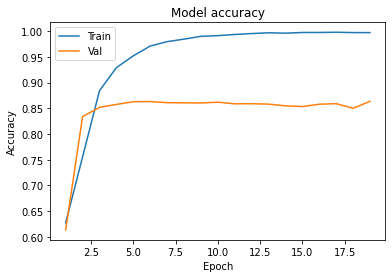

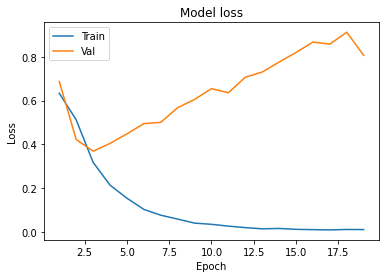

In [26]:
plot_learningCurve(history, 19)

### Test Architecture

In [27]:
y_pred = (model.predict(X_test, batch_size = 128) > 0.5).astype("int32")

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))

Correct Prediction: 8636
Wrong Prediction: 1364
Accuracy: 86.36


### Load model

In [28]:
loaded_model = load_model('models/imdb.017-0.0081-0.9981-0.8587-0.8591.hdf5')

In [29]:
def predict(review):
  regex = re.compile(r'[^a-zA-Z\s]')
  review = regex.sub('', review)

  words = review.split(' ')
  filtered = [w for w in words if w not in english_stops]
  filtered = ' '.join(filtered)
  filtered = [filtered.lower()]

  tokenize_words = token.texts_to_sequences(filtered)
  tokenize_words = pad_sequences(tokenize_words, maxlen=max_review_length, padding='post', truncating='post')
  result = loaded_model.predict(tokenize_words)
  value = result.astype(float).squeeze().item()
  sentiment = 'Positive' if result > 0.5 else 'Negative'

  return ('{:.3f}'.format(value), sentiment)

In [30]:
print('Result: {}'.format(predict('The Most Overrated Movie of All Time')))
print('Result: {}'.format(predict('Tied for the best movie I have ever seen')))

Result: ('0.001', 'Negative')
Result: ('0.992', 'Positive')
